<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Setup-et-importation-des-images" data-toc-modified-id="1.-Setup-et-importation-des-images-1">1. Setup et importation des images</a></span></li><li><span><a href="#2.-Extraction-des-features-des-images-avec-ResNet-50." data-toc-modified-id="2.-Extraction-des-features-des-images-avec-ResNet-50.-2">2. Extraction des features des images avec ResNet 50.</a></span></li><li><span><a href="#3.-Visualisation-des-différentes-étapes-de-preprocessing-d'image" data-toc-modified-id="3.-Visualisation-des-différentes-étapes-de-preprocessing-d'image-3">3. Visualisation des différentes étapes de preprocessing d'image</a></span></li><li><span><a href="#4.-PCA-et-réduction-dimensionnelle" data-toc-modified-id="4.-PCA-et-réduction-dimensionnelle-4">4. PCA et réduction dimensionnelle</a></span></li></ul></div>

# 1. Setup et importation des images

In [1]:
import os

# for jupyter to find spark...
import findspark
findspark.init()

# packages allowing to get s3 files from the notebook
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'

# import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

# get id and secret key from credential file
path_cred = os.path.join(os.getcwd(),
            "valentin_credentials.csv")
with open(path_cred,'r') as f:
        msg = f.read()
ID = str(msg).split('\n')[1].split(',')[2]
KEY = str(msg).split('\n')[1].split(',')[3]

# set "temporary" environment variables
os.environ["AWS_ACCESS_KEY_ID"]=ID
os.environ["AWS_SECRET_ACCESS_KEY"]=KEY

# create spark context
sc = SparkContext.getOrCreate()
hadoop_conf=sc._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3.impl",
               "org.apache.hadoop.fs.s3native.NativeS3FileSystem")
#hadoop_conf.set("fs.s3.awsAccessKeyId", ID)
#hadoop_conf.set("fs.s3.awsSecretAccessKey", KEY)

# create spark session
spark = SparkSession.builder.appName('FeatExtr').getOrCreate()

# get data from s3
from pyspark.ml.image import ImageSchema
PREFIX = 'sample_img'
bucket='awsbucketcloudproject'
data_path = 's3://{}/{}'.format(bucket, PREFIX)

In [2]:
# On importe les images
images_df = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(data_path)
# "pathGlobFilter" => permet d'importer uniquement les fichier correspondant au modéle (ici les formats jpg)
# "recursiveFileLookup" => permet de lire aussi les sous répertoires présents dans le répertoire principal
display(images_df.limit(5))

# Affichage des premières lignes du  dataframe contenant les images
images_df.show(3)

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary]

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://awsbucketclo...|2021-03-10 16:11:22|  7357|[FF D8 FF E0 00 1...|
|s3://awsbucketclo...|2021-03-10 16:11:22|  7325|[FF D8 FF E0 00 1...|
|s3://awsbucketclo...|2021-03-10 16:11:23|  7210|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 3 rows



# 2. Extraction des features des images avec ResNet 50.

In [3]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.sql.functions import col, pandas_udf, PandasUDFType

# Utilisation du réseau de neurones Resnet-50 déjà pré-entraîné
# On ne conserve pas le pooling final
# On retire la couche fully-connected: (include_top=False) 

model = ResNet50(include_top=False)

In [4]:
# On utilise le broadcast de SparkContext pour partager dans le cluster des valeurs  (ICI les poids du modéle) en lecture-seule
# Cela permet de réduire les coûts de communication 

bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Retourne un modèle ResNet50 avec la couche supérieure enlevée (fully-connected) et 
    des pondérations en broadcast déjà pré-entraînés. 
    On retire la couche supérieure car c'est celle qui permet de faire une classification, or 
    ici on se sert du modéle pour extraire des features.
    
    Pooling = "avg" est utilisé pour réduire le nombre de caractéristiques à 2048
    """

    model = ResNet50(weights=None, include_top=False, pooling='avg')
    #on ajoute les pondérations
    model.set_weights(bc_model_weights.value)
    
    return model

In [5]:
#préprocessing et extraction de features
import pandas as pd
from PIL import Image, ImageOps
import cv2
import numpy as np
import io

def preprocess(content):
    """
    Fonction appliquant différentes étapes de pre-processing d'images.
    """
    
    img = Image.open(io.BytesIO(content)).resize([224, 224])   # on ouvre et redimensionne l'image car Resnet 50 ne prend 
                                                               #  en charge que des images de taille 224x224
    img2 = np.asarray(img) # Changer le type d'image en matrice          
    img3 = cv2.fastNlMeansDenoisingColored(img2,None,10,10,7,21) # Flou rapide
    img4 = np.array(ImageOps.equalize(ImageOps.autocontrast(Image.fromarray(img3),cutoff=5))) # Autocontraste & égalisation
    
    blur_val = (5, 5)# Flou Gaussien
    img5 = cv2.GaussianBlur(img4,blur_val,0) 
    
    arr = img_to_array(img5) # Préparation au pre-process de Keras
    return preprocess_input(arr) # Fonction 'preprocess_input' de Keras utilisée dans le modèle ResNet50
                                 # c'est un ensemble de préprocessing propres à l'utilisation de ResNet 

    
    
    
def featurize_series(model, content_series):
    """
    Retourne un pd.Series des features de l'image, 
    """
    
    input = np.stack(content_series.map(preprocess))
  # La ligne de code suivante permet d'extraire les features des images
    preds = model.predict(input)
  # Pour certaines couches, les caractéristiques de sortie sont des tensors multidimensionnels
  # On aplatit les caractéristiques de tensors en vecteurs pour faciliter le stockage dans les dataframes Spark
  # la fonction flatten() envoie une copie du tableau réduit à une seule dimension 
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [6]:
@pandas_udf('array<double>', PandasUDFType.SCALAR_ITER)

def featurize_udf(content_series_iter):
    '''
    Cette méthode est un Itérateur Scalaire (pandas UDF signifiant User-Defined Functions) qui complète
    la fonction de featurisation.
    Cela renvoie une colonne Spark DataFrame de type ArrayType(FloatType).
  
    param content_series_iter : Cet argument est un itérateur sur des lots de données, où chaque lot
    est une série de données d'images pandas.
    '''
    
  # Avec les pandas UDF Scalar Iterator, on peut charger le modèle une fois et le réutiliser ensuite
  # pour plusieurs lots de données. Cela permet d'amortir les frais liés au chargement de grands modèles.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/opt/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [7]:
# On lance la recherche de features sur notre dataframe Spark (peut prendre du temps)

features_df = images_df.repartition(4).select(col("path"), featurize_udf("content").alias("features"))

In [8]:
features_df.show()

+--------------------+--------------------+
|                path|            features|
+--------------------+--------------------+
|s3://awsbucketclo...|[0.32091039419174...|
|s3://awsbucketclo...|[0.01127893570810...|
|s3://awsbucketclo...|[0.01459772698581...|
|s3://awsbucketclo...|[1.11668694019317...|
|s3://awsbucketclo...|[0.01745455525815...|
|s3://awsbucketclo...|[0.0, 0.267588615...|
|s3://awsbucketclo...|[0.18632036447525...|
|s3://awsbucketclo...|[0.58571386337280...|
|s3://awsbucketclo...|[0.05436016619205...|
|s3://awsbucketclo...|[1.51123523712158...|
|s3://awsbucketclo...|[1.52448189258575...|
|s3://awsbucketclo...|[2.03695654869079...|
|s3://awsbucketclo...|[0.14516119658946...|
|s3://awsbucketclo...|[1.43152773380279...|
|s3://awsbucketclo...|[1.30824232101440...|
|s3://awsbucketclo...|[0.76417243480682...|
|s3://awsbucketclo...|[0.17907780408859...|
|s3://awsbucketclo...|[0.31793171167373...|
|s3://awsbucketclo...|[0.94306385517120...|
|s3://awsbucketclo...|[0.3510416

# 3. Visualisation des différentes étapes de preprocessing d'image

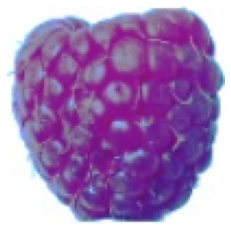

In [9]:
import matplotlib.pyplot as plt

# Image originale
img = cv2.imread("324_100.jpg")# l'image est lue en format  BGR 
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# On la convertie en format  RGB
plt.imshow(rgb_img)
plt.axis('off')
plt.show()

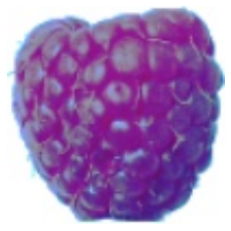

In [10]:
# Resizing
resizing = cv2.resize(rgb_img, (224, 224))
plt.imshow(resizing)
plt.axis('off')
plt.show()

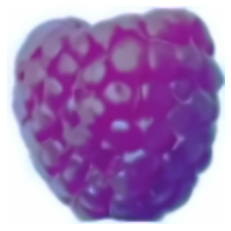

In [11]:
# Réduction de bruits
f_denoising = cv2.fastNlMeansDenoisingColored(resizing,None,10,10,7,21)
plt.imshow(f_denoising)
plt.axis('off')
plt.show()

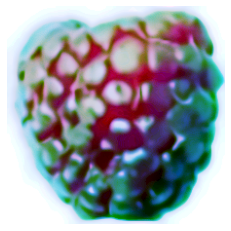

In [12]:
#Autocontrast & Equalization
auto_C_E = np.array(ImageOps.equalize(ImageOps.autocontrast(Image.fromarray(f_denoising),cutoff=5)))
plt.imshow(auto_C_E)
plt.axis('off')
plt.show()

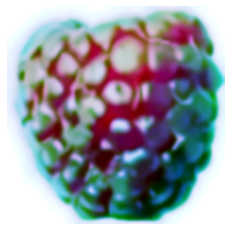

In [13]:
#Flou Gaussien
gauss = cv2.GaussianBlur(auto_C_E,(5, 5),0)
plt.imshow(gauss)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


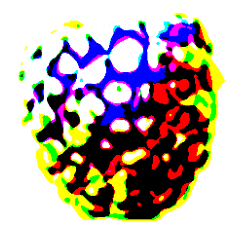

In [14]:
# Fonction de preprocessing du Resnet-50
arr = img_to_array(gauss)
arr_2 = preprocess_input(arr)
plt.imshow(arr_2)
plt.axis('off')
plt.show()

# 4. PCA et réduction dimensionnelle

In [15]:
# On ajoute une colonne 'label' au dataframe des features

from pyspark.sql.functions import split, element_at
#on récupére le type de fruit à partir du chemin de l'image.
features_df_label = features_df.withColumn('label', element_at(split(features_df['path'],"/"),-2))

In [16]:
features_df_label.show(5)

+--------------------+--------------------+-----------+
|                path|            features|      label|
+--------------------+--------------------+-----------+
|s3://awsbucketclo...|[0.32091039419174...|cauliflower|
|s3://awsbucketclo...|[0.01127893570810...|     lychee|
|s3://awsbucketclo...|[0.01459772698581...|     lychee|
|s3://awsbucketclo...|[1.11668694019317...|  Raspberry|
|s3://awsbucketclo...|[0.01745455525815...|     lychee|
+--------------------+--------------------+-----------+
only showing top 5 rows



In [17]:
# On convertit les données de features en vecteurs

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

#Ici on construit une User defined Fonction qui transforme les listes de features en vecteurs denses.
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

# On applique cette UDF à la colonne "features" de notre dataframe 
df_with_vectors = features_df_label.select(features_df_label["path"],
                                           features_df_label["label"],
                                           list_to_vector_udf(features_df_label["features"]).alias("features"))

In [18]:
# Recherche du nombre optimal de dimensions pour la réduction dimensionnelle des features

from pyspark.ml.feature import PCA

num_components = 2048
pca_opt = PCA(k = num_components,
         inputCol="features", 
         outputCol="features_pca")

model = pca_opt.fit(df_with_vectors)
scree = model.explainedVariance

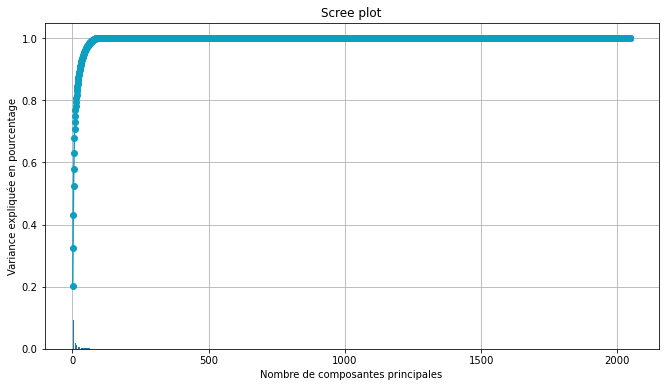

In [30]:
# Scree plot pour déterminer le nombre optimal de composantes principales

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(11,6))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="#0D9FBF",marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée en pourcentage")
plt.title("Scree plot")
plt.grid()
plt.show(block=False)

In [20]:
# On chercher à  trouver le nombre de composantes principales à conserver.
# On se fixe ici de converser au moins 85 % de l'inertie .
nbr_pca=0
for i in range(50):
    a = scree.cumsum()[i]
    if a >= 0.85:
        print("{} composantes principales expliquent au moins 85% de la variance totale".format(i))
        print("Valeur exacte de variance expliquée:{}%".format(a*100))
        nbr_pca=i
        break

18 composantes principales expliquent au moins 85% de la variance totale
Valeur exacte de variance expliquée:85.39310180138955%


In [21]:
# Réduction dimensionnelle PCA suivant le nombre de dimensions choisies précédemment (en k)

from pyspark.ml.feature import PCA
# On pratique la PCA  sur la colonne "Feature" de notre dataframe et on recuperera le resultat dans une nouvelle colonne "Feature_pca"
pca = PCA(k=18,inputCol="features",outputCol="features_pca")

# Entraînement du PCA

model = pca.fit(df_with_vectors)

In [22]:
# Dataframe post-PCA

df_pca = model.transform(df_with_vectors)
df_pca.show(5)

+--------------------+-----------+--------------------+--------------------+
|                path|      label|            features|        features_pca|
+--------------------+-----------+--------------------+--------------------+
|s3://awsbucketclo...|cauliflower|[0.32091039419174...|[7.14512906624782...|
|s3://awsbucketclo...|     lychee|[0.01127893570810...|[29.2955284869144...|
|s3://awsbucketclo...|     lychee|[0.01459772698581...|[29.7113897774194...|
|s3://awsbucketclo...|  Raspberry|[1.11668694019317...|[13.1517781936579...|
|s3://awsbucketclo...|     lychee|[0.01745455525815...|[30.7557216055232...|
+--------------------+-----------+--------------------+--------------------+
only showing top 5 rows



In [23]:
# Dataframe final avec chemin vers images, labels et features obtenus par PCA (on enlève la colonne features)

df_final = df_pca[['path','label','features_pca']]
df_final.show(5)

+--------------------+-----------+--------------------+
|                path|      label|        features_pca|
+--------------------+-----------+--------------------+
|s3://awsbucketclo...|cauliflower|[7.14512906624782...|
|s3://awsbucketclo...|     lychee|[29.2955284869144...|
|s3://awsbucketclo...|     lychee|[29.7113897774194...|
|s3://awsbucketclo...|  Raspberry|[13.1517781936579...|
|s3://awsbucketclo...|     lychee|[30.7557216055232...|
+--------------------+-----------+--------------------+
only showing top 5 rows



Au final on obtient donc un dataframe de 3 colonnes, ou les resultats de L'ACP sont un vecteur de taille 18 .

In [24]:
# Enregistrement du dataframe final avec la méthode parquet

df_final.write.parquet("s3a://awsbucketcloudproject/features_sample3.parquet")

In [25]:
# On travaille maintenant avec la librairie pandas
# Transformation en dataframe pandas avec séparation des features dans une colonne dédiée


df_p = df_final.toPandas()
df_p.sample(3)

,path,label,features_pca
13,s3://awsbucketcloudproject/sample_img/carambul...,carambula,"[0.6246031893417456, 5.920308922397911, -0.738..."
25,s3://awsbucketcloudproject/sample_img/lychee/1...,lychee,"[33.399355574355106, -2.7449060656775157, -3.8..."
63,s3://awsbucketcloudproject/sample_img/cherry w...,cherry wax red,"[-5.610222575732868, -13.776789096924523, 7.94..."


Pour faciliter les manipulations, on modifie la colonne "features_pca", en la transformant en 18 nouvelles colonnes
Dans la colonne 0 on conserve les valeurs de la PCA 1
dans la colonne 1  on conserve les valeurs de la PCA 2 etc....

In [26]:
# Mise en place d'un Dataframe avec pour chaque fruit une séparation en colonne de chaque feature identifiée

col=["Label"]
df_final = pd.DataFrame(np.zeros((df_p.shape[0], nbr_pca)))
for i in range(nbr_pca):
    df_final.loc[:,i] = df_p["features_pca"].apply(lambda x : x[i])
    col.append("PCA n°{}".format(i+1))

df_final_pca = pd.concat([df_p['label'], df_final], axis=1)
df_final_pca.columns=col
print(df_final_pca.shape)
print(df_final_pca.columns)

(89, 19)
Index(['Label', 'PCA n°1', 'PCA n°2', 'PCA n°3', 'PCA n°4', 'PCA n°5',
       'PCA n°6', 'PCA n°7', 'PCA n°8', 'PCA n°9', 'PCA n°10', 'PCA n°11',
       'PCA n°12', 'PCA n°13', 'PCA n°14', 'PCA n°15', 'PCA n°16', 'PCA n°17',
       'PCA n°18'],
      dtype='object')


In [27]:
df_final_pca.head(5)

,Label,PCA n°1,PCA n°2,PCA n°3,PCA n°4,PCA n°5,PCA n°6,PCA n°7,PCA n°8,PCA n°9,PCA n°10,PCA n°11,PCA n°12,PCA n°13,PCA n°14,PCA n°15,PCA n°16,PCA n°17,PCA n°18
0,cauliflower,7.145129,15.137948,-8.008099,13.715654,-10.078492,6.037776,1.316746,5.627573,3.667253,-3.884210,0.185937,-0.429695,-4.370774,4.238893,-6.994780,0.629585,8.824659,-0.917054
1,lychee,29.295528,-4.388515,-6.852858,-15.774737,-6.403747,2.485312,2.445605,3.481115,-0.136848,-4.244133,-4.344730,-2.490077,-4.015359,0.792310,-7.654412,1.283702,2.681614,-6.158535
2,lychee,29.711390,-4.427069,-7.796836,-16.590449,-6.461293,2.478165,2.672138,3.616423,-0.974300,-4.466565,-4.329377,-2.938623,-3.871917,1.087606,-7.409049,1.244209,2.822464,-6.390120
3,Raspberry,13.151778,-5.490725,13.812362,5.620433,4.183579,11.283484,-3.687804,5.750776,1.418494,-4.150735,-2.516540,-3.306903,-1.316101,2.880592,-0.461058,0.105905,1.513535,-3.744669
4,lychee,30.755722,-4.291984,-4.248815,-14.810139,-4.893094,4.602456,2.557559,5.293632,2.059200,-4.574606,-0.760892,-1.319719,-1.511665,4.949117,-1.993817,-2.233144,3.301352,-3.974076


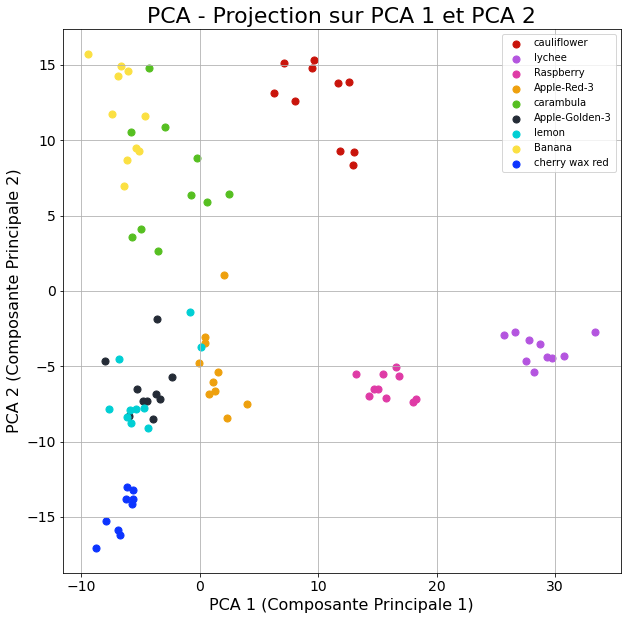

In [28]:
# Visualisation des différents fruits par projection sur les 2 axes principaux d'inertie

plt.figure(figsize=(10,10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('PCA 1 (Composante Principale 1)',fontsize=16)
plt.ylabel('PCA 2 (Composante Principale 2)',fontsize=16)
couleurs=["#c9140b","#b455df","#df3ba6","#eea00d","#56bf21","#242b36","#00cfd4","#fbe042","#0c34ff","#bb5cd4","#fd00ff","#ff008d"]
i=0
for fruit in df_final_pca['Label'].unique():
    dfred = df_final_pca.loc[df_final_pca['Label']==fruit]
    plt.scatter(dfred['PCA n°1'], dfred['PCA n°2'], label=fruit, s=50,c=couleurs[i])
    i+=1

plt.title("PCA - Projection sur PCA 1 et PCA 2",fontsize=22)
plt.grid()
plt.legend()    
plt.show()

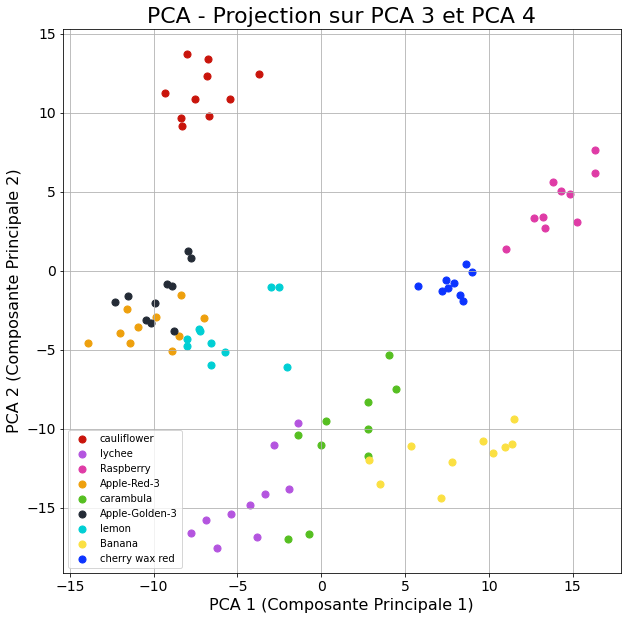

In [29]:
# Visualisation des différents fruits par projection sur les  axes d'ACP 3 et 4 

plt.figure(figsize=(10,10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('PCA 1 (Composante Principale 1)',fontsize=16)
plt.ylabel('PCA 2 (Composante Principale 2)',fontsize=16)
i=0
for fruit in df_final_pca['Label'].unique():
    dfred = df_final_pca.loc[df_final_pca['Label']==fruit]
    plt.scatter(dfred['PCA n°3'], dfred['PCA n°4'], label=fruit, s=50,c=couleurs[i])
    i+=1

plt.title("PCA - Projection sur PCA 3 et PCA 4",fontsize=22)
plt.grid()
plt.legend()    
plt.show()